# FERM 501 – Applied Financial Economics - Final Group Project
# - Project by: N. Emir Eğilli, Burak Kargın, Z. Yiğit Atalay

## 1. Download the necessary data for the securities and the factor data you need for expected return calculations.

### INITIAL REMARKS:
We plan on using a multi-factor model along with min-variance portfolio optimization for this project.
- Daily data for Fama-French 5-factors is downloaded from: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
- Daily data for selected stocks is downloaded via "yfinance" library.

In [1]:
# Let's import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize as optimization
from scipy.optimize import minimize
import yfinance as yf
from datetime import date, datetime, timedelta
from tabulate import tabulate
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\emir.e\Anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# First, let's create the function to download the stocks data
def download_stocks(tickers_str, start="2021-02-26", end="2023-12-29", csv_file="stock_data.csv"):
    # Split the string of tickers into a list
    tickers = tickers_str.split(", ")

    # Download the data using yfinance
    data = yf.download(tickers, start=start, end=end)

    # Extract the 'Adj Close' data
    adj_close_data = data['Adj Close']

    # Export the data to a CSV file
    adj_close_data.to_csv(csv_file)

    return adj_close_data

In [3]:
# Since we had Fama-French data up to 2024-02-29, we proceed to use 3 years daily data until that date
download_stocks("UBER, MSFT, KO, V, SBUX, XOM, TTE, MCD, IBM, LMT", "2021-02-26", "2024-02-29")

[*********************100%***********************]  10 of 10 completed


,IBM,KO,LMT,MCD,MSFT,SBUX,TTE,UBER,V,XOM
Date,,,,,,,,,,
2021-02-26,98.671539,44.362385,304.200287,192.836288,226.404968,101.495163,38.071461,51.750000,207.793106,48.002411
2021-03-01,100.173225,45.186424,307.166321,194.810135,230.847717,100.405357,38.358624,54.400002,211.941330,49.794666
2021-03-02,99.833069,45.367531,311.882416,195.203049,227.856598,100.715378,38.530941,54.650002,211.099960,49.503315
2021-03-03,101.517273,45.258865,314.019440,192.536972,221.708893,99.794670,39.015045,56.110001,210.199844,49.900612
2021-03-04,99.650558,45.222645,311.569305,191.620209,220.900223,98.545113,39.646832,53.070000,206.922348,51.834126
...,...,...,...,...,...,...,...,...,...,...
2024-02-22,184.210007,60.664761,425.766174,294.245880,411.649994,95.779999,63.377098,78.029999,283.750000,104.760002
2024-02-23,185.720001,60.714363,427.979889,296.065521,410.339996,95.620003,63.742702,78.199997,283.600006,103.839996
2024-02-26,184.130005,60.228252,426.054016,295.439087,407.540009,94.279999,63.535202,78.360001,284.149994,104.250000


In [4]:
def concat_factors_with_stocks(stock_csv="stock_data.csv", factors_csv="FF5_daily.CSV", output_csv="combined_data.csv"):
    # Load the stock data
    stock_data = pd.read_csv(stock_csv, index_col=0, parse_dates=True)

    # Load the Fama-French 5 Factors data, skipping initial rows and setting the first data row as header
    ff_data = pd.read_csv(factors_csv, skiprows=3, index_col=0, parse_dates=True)

    # Convert the date index from YYYYMMDD format to datetime format
    ff_data.index = pd.to_datetime(ff_data.index, format='%Y%m%d')

    # Concatenate the stock data with the Fama-French 5 Factors data based on dates
    combined_data = pd.concat([stock_data, ff_data], axis=1, join='inner')

    # Save the combined data to a new CSV file
    combined_data.to_csv(output_csv)

    return combined_data

In [5]:
combined_data = concat_factors_with_stocks(factors_csv="FF5_daily.CSV")

In [6]:
combined_data

,IBM,KO,LMT,MCD,MSFT,SBUX,TTE,UBER,V,XOM,Mkt-RF,SMB,HML,RMW,CMA,RF
2021-02-26,98.671539,44.362385,304.200287,192.836288,226.404968,101.495163,38.071461,51.750000,207.793106,48.002411,-0.28,0.34,-1.58,-0.04,-0.37,0.000
2021-03-01,100.173225,45.186424,307.166321,194.810135,230.847717,100.405357,38.358624,54.400002,211.941330,49.794666,2.63,1.11,0.23,-0.41,0.23,0.000
2021-03-02,99.833069,45.367531,311.882416,195.203049,227.856598,100.715378,38.530941,54.650002,211.099960,49.503315,-1.05,-0.77,1.23,0.62,0.20,0.000
2021-03-03,101.517273,45.258865,314.019440,192.536972,221.708893,99.794670,39.015045,56.110001,210.199844,49.900612,-1.57,0.64,3.56,1.67,1.05,0.000
2021-03-04,99.650558,45.222645,311.569305,191.620209,220.900223,98.545113,39.646832,53.070000,206.922348,51.834126,-1.70,-1.11,1.71,1.29,0.44,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,184.210007,60.664761,425.766174,294.245880,411.649994,95.779999,63.377098,78.029999,283.750000,104.760002,2.01,-1.56,-1.30,0.38,-1.18,0.021
2024-02-23,185.720001,60.714363,427.979889,296.065521,410.339996,95.620003,63.742702,78.199997,283.600006,103.839996,0.02,0.32,-0.03,0.09,-0.11,0.021
2024-02-26,184.130005,60.228252,426.054016,295.439087,407.540009,94.279999,63.535202,78.360001,284.149994,104.250000,-0.26,0.97,-0.11,-0.74,-0.01,0.021
2024-02-27,184.869995,59.861187,427.294922,292.098114,407.480011,94.129997,63.772343,78.750000,283.170013,104.029999,0.27,1.24,-0.45,-1.14,0.67,0.021


### COMMENTS:

Below are our factors for the Fama-French model: 

- Mkt-RF (Market Risk Premium): This is the excess return on the market portfolio over the risk-free rate. It represents the additional return investors expect for taking on the higher risk of investing in the stock market over a risk-free asset. A positive value suggests the market is expected to perform better than risk-free securities, indicating a higher risk appetite among investors.

- SMB (Small Minus Big): This factor represents the size premium and is calculated as the excess return of portfolios of small-cap stocks over portfolios of large-cap stocks. It captures the historical tendency for smaller companies to outperform larger ones, which is thought to occur due to the higher risk associated with smaller companies.

- HML (High Minus Low): This factor measures the value premium, calculated as the excess return of portfolios of high book-to-market (value) stocks over low book-to-market (growth) stocks. The factor is based on the observation that companies with high book-to-market ratios (value stocks) tend to outperform those with low book-to-market ratios (growth stocks), possibly due to the higher perceived risk of value stocks.

- RMW (Robust Minus Weak): This factor captures the profitability premium and is the excess return of portfolios of stocks with high operating profitability over those with low operating profitability. The idea is that companies with robust, sustainable profits should outperform those with weaker profits, as they are considered to be less risky and more capable of generating value for shareholders.

- CMA (Conservative Minus Aggressive): This factor measures the investment premium, calculated as the excess return of portfolios of stocks of companies with conservative investment policies over those with aggressive investments. It suggests that companies that invest conservatively, avoiding large, risky projects and instead focusing on smaller, safer investments, tend to perform better than those that invest more aggressively.

## 2. Form an initial portfolio at the beginning of the time period you choose. (Use Markowitz Mean-Variance Model, Min. Var. Model or Risk Parity model)

+---------+----------+
| Stock   |   Weight |
+=========+==========+
| IBM     |   0.1354 |
+---------+----------+
| KO      |   0.2839 |
+---------+----------+
| LMT     |   0.1784 |
+---------+----------+
| MCD     |   0.258  |
+---------+----------+
| MSFT    |   0.031  |
+---------+----------+
| SBUX    |   0      |
+---------+----------+
| TTE     |   0.0843 |
+---------+----------+
| UBER    |   0.0151 |
+---------+----------+
| V       |   0      |
+---------+----------+
| XOM     |   0.014  |
+---------+----------+

Expected Annual Return: 0.14
Expected Annual Volatility: 0.13
Sharpe Ratio: 1.09


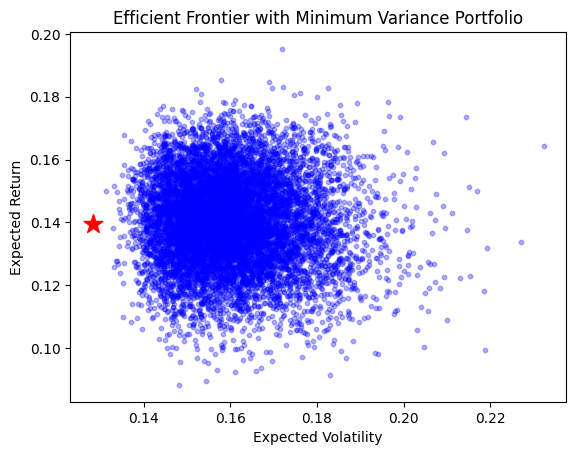

In [7]:
def markowitz_minV_from_csv(csv_file):
    """
    Constructs a Minimum Variance Portfolio from the stock data in the provided CSV file.

    Parameters
    ----------
    csv_file : str
        Path to the CSV file containing stock and factors data.

    Returns
    -------
    None
        Displays the Minimum Variance Portfolio and its characteristics.
    """
    NUM_TRADING_DAYS = 252
    NUM_PORTFOLIOS = 10000  # Number of random portfolios for the efficient frontier
    
    # Load the combined stock data from CSV
    data = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    
    # Assume the first 10 columns are stock data
    stock_data = data.iloc[:, :10]

    # Calculate daily log returns
    log_returns = np.log(stock_data / stock_data.shift(1))

    # Portfolio variance function
    def portfolio_variance(weights):
        weights = np.array(weights)
        cov_matrix = log_returns.cov() * NUM_TRADING_DAYS
        portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
        return portfolio_var

    # Constraints and bounds
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(stock_data.shape[1]))
    init_guess = np.array([1./stock_data.shape[1]]*stock_data.shape[1])
    
    # Minimize the portfolio variance to find the minimum variance portfolio
    opt_results = minimize(portfolio_variance, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    optimal_weights = opt_results.x

    # Expected portfolio performance
    expected_return = np.sum(log_returns.mean() * optimal_weights) * NUM_TRADING_DAYS
    expected_volatility = np.sqrt(portfolio_variance(optimal_weights))
    sharpe_ratio = expected_return / expected_volatility

    # Tabulate optimal weights
    weights_table = [[stock, f"{weight:.4f}"] for stock, weight in zip(stock_data.columns, optimal_weights)]
    print(tabulate(weights_table, headers=["Stock", "Weight"], tablefmt="grid"))

    # Print expected returns, volatility, and Sharpe ratio
    print(f"\nExpected Annual Return: {expected_return:.2f}")
    print(f"Expected Annual Volatility: {expected_volatility:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Efficient Frontier
    portfolio_returns = []
    portfolio_volatilities = []

    for _ in range(NUM_PORTFOLIOS):
        weights = np.random.random(stock_data.shape[1])
        weights /= np.sum(weights)
        returns = np.sum(log_returns.mean() * weights) * NUM_TRADING_DAYS
        volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * NUM_TRADING_DAYS, weights)))
        portfolio_returns.append(returns)
        portfolio_volatilities.append(volatility)

    plt.scatter(portfolio_volatilities, portfolio_returns, c='blue', marker='o', s=10, alpha=0.3)
    plt.scatter(expected_volatility, expected_return, c='red', marker='*', s=200)  # Minimum Variance Portfolio
    plt.title('Efficient Frontier with Minimum Variance Portfolio')
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.show()


markowitz_minV_from_csv('combined_data.csv')

## 3. Divide the time period into two parts (for example: 7 years for train + 3 years for out of sample). Choose your own length for periods. Calculate the expected returns for each security using the first part (train data).

In [8]:
# Let's start with a simple function that will help us split our training and test timeframes on our daily data by 80%
def traintest_split(start, end, percentage_split):
    """
    Splits the given date range into training and test periods based on percentage split for training data.

    Parameters:
    start (str): Start date of the entire period in 'YYYY-MM-DD' format.
    end (str): End date of the entire period in 'YYYY-MM-DD' format.

    Returns:
    None: Prints the training and test period date ranges.
    """
    # Convert start and end dates to datetime objects
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')

    # Calculate the total number of days in the given period
    total_days = (end_date - start_date).days

    # Calculate the number of days in the training period (80% of the total)
    train_days = int(total_days * percentage_split)

    # Calculate the end date of the training period
    train_end_date = start_date + timedelta(days=train_days)

    # The test period starts the day after the training period ends
    test_start_date = train_end_date + timedelta(days=1)

    # Format dates for printing
    train_end = train_end_date.strftime('%Y-%m-%d')
    test_start = test_start_date.strftime('%Y-%m-%d')

    print(f'Training period: {start} to {train_end}')
    print(f'Test period: {test_start} to {end}')

In [9]:
traintest_split(start="2021-02-26", end="2024-02-29", percentage_split= 0.8)

Training period: 2021-02-26 to 2023-07-24
Test period: 2023-07-25 to 2024-02-29


In [10]:
# Filter for the training period
training_data = combined_data['2021-02-26':'2023-07-24']

# Calculate excess returns for IBM
stock = 'IBM'
excess_returns = training_data[stock] - training_data['RF']
factors = training_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

# Running OLS regression
X = sm.add_constant(factors)
model = sm.OLS(excess_returns, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6902
Date:                Tue, 09 Apr 2024   Prob (F-statistic):              0.631
Time:                        11:17:41   Log-Likelihood:                -2117.1
No. Observations:                 605   AIC:                             4246.
Df Residuals:                     599   BIC:                             4273.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        121.2199      0.329    368.532      0.0

In [11]:
# Load the data
data = pd.read_csv('combined_data.csv', index_col=0, parse_dates=True)

# Training date range
start_date = '2021-02-26'
end_date = '2023-07-24'

# Filter data for the specified date range
data = data.loc[start_date:end_date]

# Calculate the excess return for IBM
data['IBM_excess'] = data['IBM'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'IBM_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_IBM = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_IBM.summary())

                            OLS Regression Results                            
Dep. Variable:             IBM_excess   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     41.24
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.76e-36
Time:                        11:17:41   Log-Likelihood:                 1751.6
No. Observations:                 604   AIC:                            -3491.
Df Residuals:                     598   BIC:                            -3465.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0063      0.001    -11.581      

In [12]:
# Calculate the excess return for KO
data['KO_excess'] = data['KO'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'KO_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_KO = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_KO.summary())

                            OLS Regression Results                            
Dep. Variable:              KO_excess   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     46.98
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.59e-41
Time:                        11:17:42   Log-Likelihood:                 1869.9
No. Observations:                 604   AIC:                            -3728.
Df Residuals:                     598   BIC:                            -3701.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0064      0.000    -14.292      

In [13]:
# Calculate the excess return for LMT
data['LMT_excess'] = data['LMT'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'LMT_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_LMT = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_LMT.summary())

                            OLS Regression Results                            
Dep. Variable:             LMT_excess   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     23.42
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.58e-21
Time:                        11:17:42   Log-Likelihood:                 1693.7
No. Observations:                 604   AIC:                            -3375.
Df Residuals:                     598   BIC:                            -3349.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0061      0.001    -10.151      

In [14]:
# Calculate the excess return for MCD
data['MCD_excess'] = data['MCD'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'MCD_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_MCD = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_MCD.summary())

                            OLS Regression Results                            
Dep. Variable:             MCD_excess   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     44.44
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.20e-39
Time:                        11:17:43   Log-Likelihood:                 1860.6
No. Observations:                 604   AIC:                            -3709.
Df Residuals:                     598   BIC:                            -3683.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0062      0.000    -13.578      

In [15]:
# Calculate the excess return for MSFT
data['MSFT_excess'] = data['MSFT'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'MSFT_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_MSFT = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_MSFT.summary())

                            OLS Regression Results                            
Dep. Variable:            MSFT_excess   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     205.6
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          2.46e-127
Time:                        11:17:43   Log-Likelihood:                 1818.3
No. Observations:                 604   AIC:                            -3625.
Df Residuals:                     598   BIC:                            -3598.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0060      0.000    -12.256      

In [16]:
# Calculate the excess return for SBUX
data['SBUX_excess'] = data['SBUX'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'SBUX_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_SBUX = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_SBUX.summary())

                            OLS Regression Results                            
Dep. Variable:            SBUX_excess   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     73.73
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           4.07e-60
Time:                        11:17:44   Log-Likelihood:                 1678.3
No. Observations:                 604   AIC:                            -3345.
Df Residuals:                     598   BIC:                            -3318.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0067      0.001    -10.764      

In [17]:
# Calculate the excess return for TTE
data['TTE_excess'] = data['TTE'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'TTE_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_TTE = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_TTE.summary())

                            OLS Regression Results                            
Dep. Variable:             TTE_excess   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     80.14
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.54e-64
Time:                        11:17:44   Log-Likelihood:                 1670.4
No. Observations:                 604   AIC:                            -3329.
Df Residuals:                     598   BIC:                            -3302.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0060      0.001     -9.505      

In [18]:
# Calculate the excess return for UBER
data['UBER_excess'] = data['UBER'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'UBER_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_UBER = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_UBER.summary())

                            OLS Regression Results                            
Dep. Variable:            UBER_excess   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     98.00
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.26e-75
Time:                        11:17:45   Log-Likelihood:                 1376.6
No. Observations:                 604   AIC:                            -2741.
Df Residuals:                     598   BIC:                            -2715.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0053      0.001     -5.186      

In [19]:
# Calculate the excess return for V
data['V_excess'] = data['V'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'V_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_V = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_V.summary())

                            OLS Regression Results                            
Dep. Variable:               V_excess   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     81.56
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           3.10e-65
Time:                        11:17:45   Log-Likelihood:                 1737.9
No. Observations:                 604   AIC:                            -3464.
Df Residuals:                     598   BIC:                            -3437.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0065      0.001    -11.643      

In [20]:
# Calculate the excess return for XOM
data['XOM_excess'] = data['XOM'].pct_change() - data['RF']

# Define the formula for the regression
formula = 'XOM_excess ~ Q("Mkt-RF") + SMB + HML + RMW + CMA'

# Perform the OLS regression using the formula
model_XOM = smf.ols(formula=formula, data=data).fit()

# Print the summary of the regression
print(model_XOM.summary())

                            OLS Regression Results                            
Dep. Variable:             XOM_excess   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     124.6
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           3.02e-90
Time:                        11:17:46   Log-Likelihood:                 1689.0
No. Observations:                 604   AIC:                            -3366.
Df Residuals:                     598   BIC:                            -3340.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0053      0.001     -8.797      

### COMMENTS:

The OLS regression outputs for various stocks against the Fama-French Five-Factor model reveal:

- Expected Excess Returns: The constant terms, indicating expected excess returns not explained by the factors, are generally small and negative across stocks, suggesting slight underperformance relative to the risk-free rate.

- R-squared Values: These vary, with some stocks like MSFT and XOM showing higher values, indicating that the Fama-French factors explain a significant portion of their return variability. Lower values for other stocks suggest less explanatory power.

- Factor Significance: The Mkt-RF factor is consistently significant across all stocks, indicating its strong predictive power. The significance of SMB, HML, RMW, and CMA varies, reflecting the diverse influences on different stocks.

- Statistical Significance: Factors with p-values below 0.05 are considered significant. For example, Mkt-RF is significant for all stocks, while the importance of other factors varies.

- Predictive Capability: While the models offer insights into the stocks' past performance, their ability to predict future returns needs validation on out-of-sample data.

## 4. At the beginning of the second interval (test period) increase exposure to stocks (or factors) with high predicted returns and reduce exposure to those with potentially lower returns. Or you can feed the expected returns to the Markowitz Mean-Variance model or Risk Parity model. (Choose your own criteria for the optimization and explain)

### INITIAL REMARKS:

We will try an approach on multiplying the excess returns of each stock with the weights given on our minimum variance efficient frontier.
But first, we need to see the predictive power of our model on each individual stock.

In [21]:
# Define the test date range
test_start_date = '2023-07-25'
test_end_date = '2024-02-29'

# Assuming 'data' originally contains all needed dates, re-load or ensure it includes the test date range
# If 'data' was altered, reload or adjust it to include test dates
data = pd.read_csv('combined_data.csv', index_col=0, parse_dates=True)

# Filter data for the test date range
test_data = data.loc[test_start_date:test_end_date]

# Calculate the excess return for IBM in the test period
# Here, we'll assume 'RF' values are known for the test period. If not, you'll need a method to estimate them
test_data['IBM_excess'] = test_data['IBM'].pct_change().fillna(0) - test_data['RF']

# Use the model to predict the excess returns on IBM in the test period
# The independent variables ('Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA') need to be present in 'test_data'
test_data['predicted_IBM_excess'] = model_IBM.predict(test_data)

# Print the predicted excess returns
print(test_data[['IBM_excess', 'predicted_IBM_excess']])

            IBM_excess  predicted_IBM_excess
2023-07-25   -0.022000             -0.007390
2023-07-26   -0.016727             -0.001395
2023-07-27   -0.008532             -0.009854
2023-07-28   -0.018643             -0.002211
2023-07-31   -0.016911             -0.005989
...                ...                   ...
2024-02-22    0.004097             -0.000244
2024-02-23   -0.012803             -0.006560
2024-02-26   -0.029561             -0.009661
2024-02-27   -0.016981             -0.004141
2024-02-28   -0.018674             -0.005912

[151 rows x 2 columns]


In [22]:
# Calculate the errors
mae = mean_absolute_error(test_data['IBM_excess'], test_data['predicted_IBM_excess'])
mse = mean_squared_error(test_data['IBM_excess'], test_data['predicted_IBM_excess'])
r_squared = r2_score(test_data['IBM_excess'], test_data['predicted_IBM_excess'])

# Print the performance metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r_squared}")

Mean Absolute Error (MAE): 0.01458180293977279
Mean Squared Error (MSE): 0.0002929994102351027
R-squared: -0.8805009513421642


In [23]:
test_data['MSFT_excess'] = test_data['MSFT'].pct_change().fillna(0) - test_data['RF']

# Use the model to predict the excess returns on IBM in the test period
# The independent variables ('Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA') need to be present in 'test_data'
test_data['predicted_MSFT_excess'] = model_MSFT.predict(test_data)

# Calculate the errors
mae = mean_absolute_error(test_data['MSFT_excess'], test_data['predicted_MSFT_excess'])
mse = mean_squared_error(test_data['MSFT_excess'], test_data['predicted_MSFT_excess'])
r_squared = r2_score(test_data['MSFT_excess'], test_data['predicted_MSFT_excess'])

# Print the performance metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r_squared}")

Mean Absolute Error (MAE): 0.015248483692803409
Mean Squared Error (MSE): 0.0002854679739827253
R-squared: -0.8048439459323562


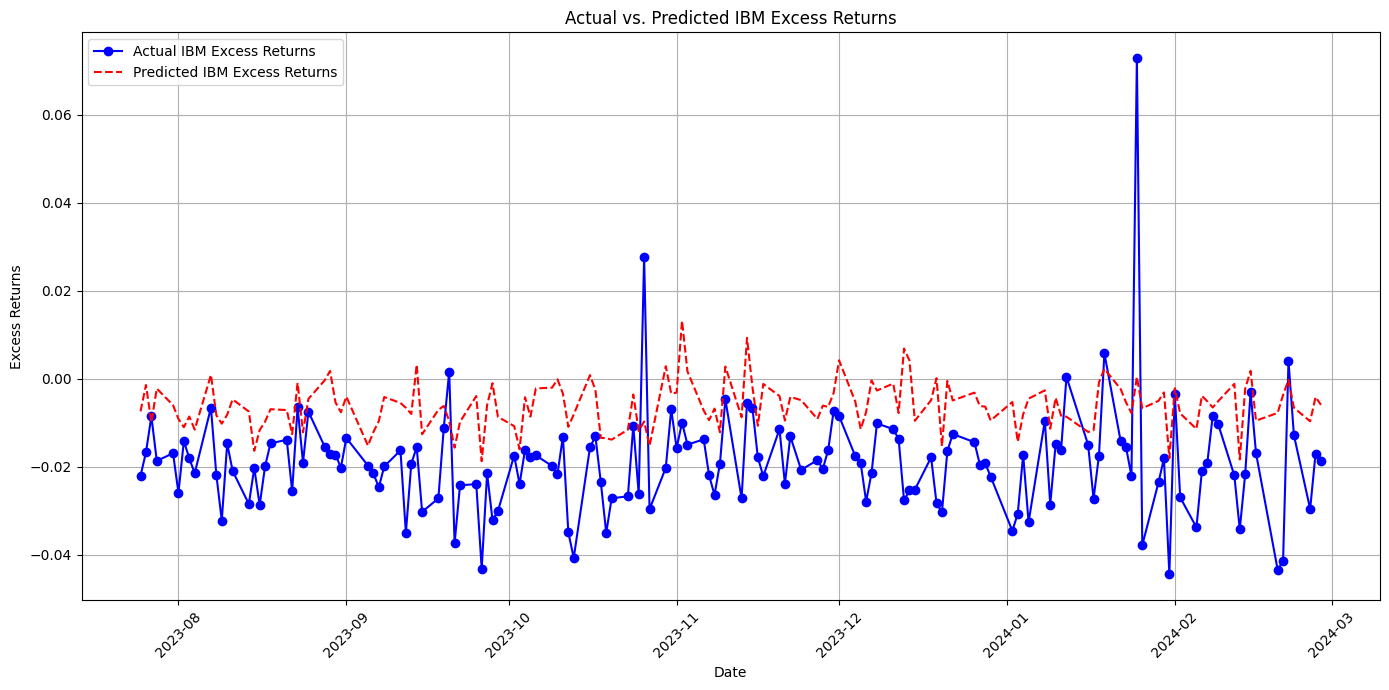

In [24]:
# Plotting the actual vs. predicted excess returns for IBM
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['IBM_excess'], label='Actual IBM Excess Returns', color='blue', marker='o')
plt.plot(test_data.index, test_data['predicted_IBM_excess'], label='Predicted IBM Excess Returns', color='red', linestyle='--')

plt.title('Actual vs. Predicted IBM Excess Returns')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### COMMENTS: 
It seems our models in out-of-sample data for individual stocks has a negative R-squared value even in our highest in-sample R-squared for MSFT. Checking the actual vs predicted returns plot for IBM also shows that the model's predictions fail to capture the spikes and tails in daily % changes. This might be due to the fact that we're testing with excess returns, where actual returns might perform better against these factors.

In that case, we can check if the returns of the overall portfolio can perform better in-sample and out-of-sample.

In [25]:
# List of your stock tickers in the portfolio
stock_tickers = ['IBM', 'KO', 'LMT', 'MCD', 'MSFT', 'SBUX', 'TTE', 'UBER', 'V', 'XOM']

# Calculate daily returns for each stock
daily_returns = data[stock_tickers].pct_change()

# Define the weight for each stock in the portfolio
weight = 0.1  # 10% weight for each stock

# Calculate weighted daily returns for each stock
weighted_daily_returns = daily_returns * weight

# Calculate the daily returns for the portfolio by summing the weighted daily returns across all stocks
portfolio_daily_returns = weighted_daily_returns.sum(axis=1)

# Add the portfolio daily returns to the DataFrame
data['EW_Returns'] = portfolio_daily_returns

# Print the first few rows to verify
print(data[['EW_Returns']].head())

            EW_Returns
2021-02-26    0.000000
2021-03-01    0.017872
2021-03-02    0.000738
2021-03-03    0.001459
2021-03-04   -0.006275


In [26]:
# Select the necessary columns from the original DataFrame
new_df = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'EW_Returns']].copy()

# Verify the new DataFrame
new_df

,Mkt-RF,SMB,HML,RMW,CMA,EW_Returns
2021-02-26,-0.28,0.34,-1.58,-0.04,-0.37,0.000000
2021-03-01,2.63,1.11,0.23,-0.41,0.23,0.017872
2021-03-02,-1.05,-0.77,1.23,0.62,0.20,0.000738
2021-03-03,-1.57,0.64,3.56,1.67,1.05,0.001459
2021-03-04,-1.70,-1.11,1.71,1.29,0.44,-0.006275
...,...,...,...,...,...,...
2024-02-22,2.01,-1.56,-1.30,0.38,-1.18,0.011112
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.001418
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,-0.003934
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,-0.000906


### COMMENTS:

Now we will test the returns with various different models. For that purpose, we will use a low-code machine learning library called PyCaret on our training period.

In [27]:
# Define the training and test period date ranges
training_start = '2021-02-26'
training_end = '2023-07-24'
test_start = '2023-07-24'
test_end = '2024-02-29'

# Split the data into training and test sets
training_data = new_df.loc[training_start:training_end]
test_data = new_df.loc[test_start:test_end]

# Verify the splits
print("Training Data:")
print(training_data.head())
print("\nTest Data:")
print(test_data.head())

Training Data:
            Mkt-RF   SMB   HML   RMW   CMA  EW_Returns
2021-02-26   -0.28  0.34 -1.58 -0.04 -0.37    0.000000
2021-03-01    2.63  1.11  0.23 -0.41  0.23    0.017872
2021-03-02   -1.05 -0.77  1.23  0.62  0.20    0.000738
2021-03-03   -1.57  0.64  3.56  1.67  1.05    0.001459
2021-03-04   -1.70 -1.11  1.71  1.29  0.44   -0.006275

Test Data:
            Mkt-RF   SMB   HML   RMW   CMA  EW_Returns
2023-07-24    0.31 -0.03  0.78  0.96 -0.22    0.004259
2023-07-25    0.25 -0.23 -0.79  0.47 -0.40   -0.000876
2023-07-26    0.02  0.87  1.02 -0.35  0.64   -0.005616
2023-07-27   -0.75 -0.81  0.26  0.39  0.13   -0.005575
2023-07-28    1.14  0.42 -0.32 -0.76 -0.39    0.006763


In [28]:
from pycaret.regression import *

In [29]:
# Initialize the setup for the regression task with the training data
regression_setup = setup(data=training_data, target='EW_Returns', session_id=123, verbose=False)

In [30]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0033,0.0000,0.0043,0.8009,0.0038,1.5444,0.1120
ridge,Ridge Regression,0.0033,0.0000,0.0043,0.8002,0.0038,1.5516,0.1100
br,Bayesian Ridge,0.0033,0.0000,0.0043,0.8002,0.0038,1.5514,0.1090
lr,Linear Regression,0.0033,0.0000,0.0043,0.8001,0.0038,1.5563,0.5690
lar,Least Angle Regression,0.0033,0.0000,0.0043,0.8001,0.0038,1.5563,0.1110
gbr,Gradient Boosting Regressor,0.0038,0.0000,0.0049,0.7430,0.0043,1.5875,0.1560
omp,Orthogonal Matching Pursuit,0.0038,0.0000,0.0050,0.7301,0.0043,1.5240,0.1100
et,Extra Trees Regressor,0.0039,0.0000,0.0050,0.7286,0.0043,1.5372,0.1760
rf,Random Forest Regressor,0.0039,0.0000,0.0050,0.7264,0.0043,1.7053,0.1760
knn,K Neighbors Regressor,0.0040,0.0000,0.0052,0.7170,0.0046,1.4337,0.1100


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

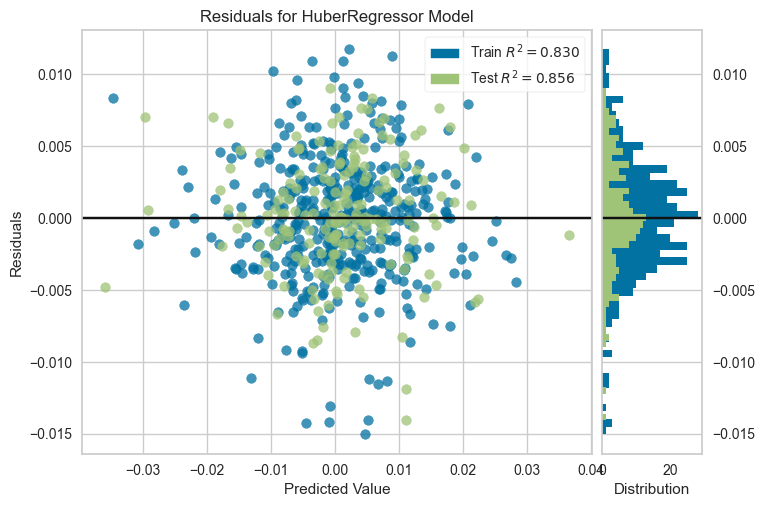

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0034,0.0000,0.0044,0.5647,0.0038,1.7051


            Mkt-RF   SMB   HML   RMW   CMA  EW_Returns  prediction_label
2023-07-24    0.31 -0.03  0.78  0.96 -0.22    0.004259          0.002751
2023-07-25    0.25 -0.23 -0.79  0.47 -0.40   -0.000876         -0.000166
2023-07-26    0.02  0.87  1.02 -0.35  0.64   -0.005616          0.002808
2023-07-27   -0.75 -0.81  0.26  0.39  0.13   -0.005575         -0.004171
2023-07-28    1.14  0.42 -0.32 -0.76 -0.39    0.006763          0.009390


In [31]:
# Plot model diagnostics
plot_model(best_model, plot='residuals')

# Predict on test data
predictions = predict_model(best_model, data=test_data)

# Display predictions
print(predictions.head())

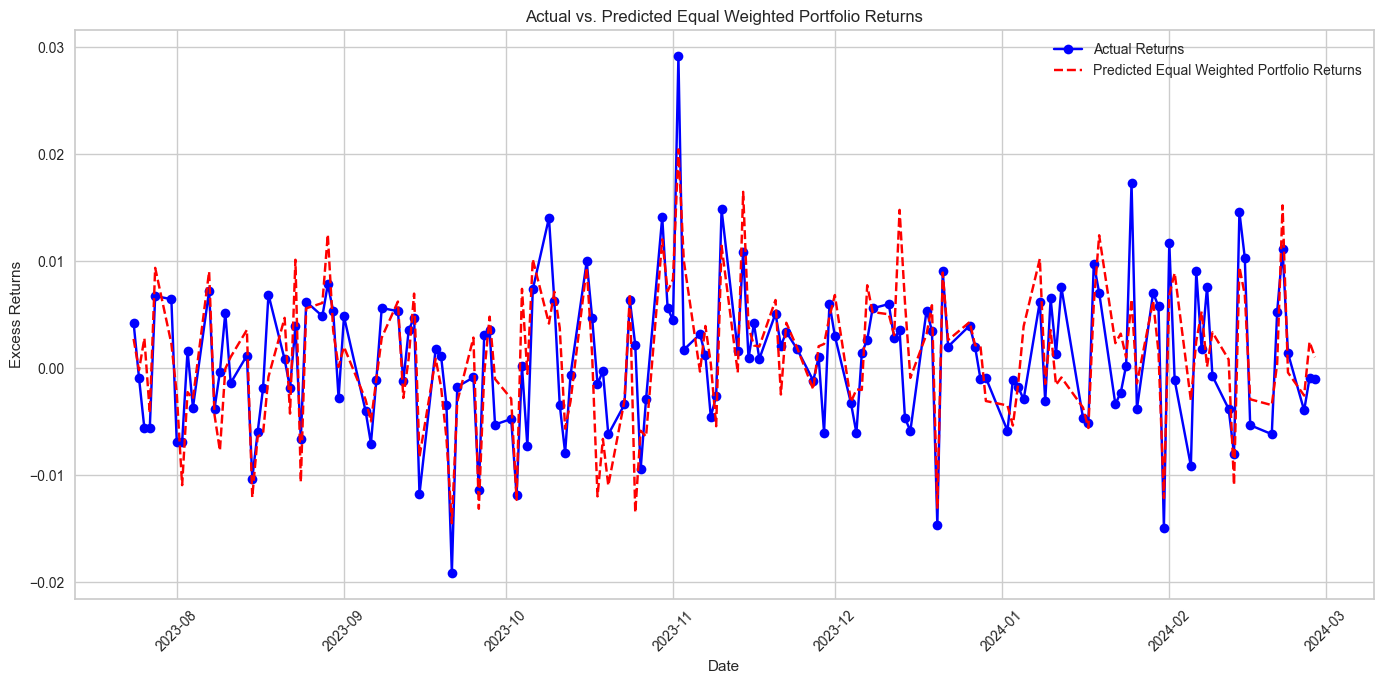

In [32]:
# Plotting the actual vs. predicted excess returns for our Equal Weighted Portfolio
plt.figure(figsize=(14, 7))
plt.plot(predictions.index, predictions['EW_Returns'], label='Actual Returns', color='blue', marker='o')
plt.plot(predictions.index, predictions['prediction_label'], label='Predicted Equal Weighted Portfolio Returns', color='red', linestyle='--')

plt.title('Actual vs. Predicted Equal Weighted Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### COMMENTS: 

The training phase results indicate strong performance with R2 values around 0.8, suggesting good explanatory power of the models for the training data. However, the drop in R2 value to 0.5647 in the test phase for the Huber Regressor points to decreased predictive accuracy, likely due to overfitting or changing market conditions. However it's expected since we're working with daily data.

Huber Regression is a type of robust regression that is less sensitive to outliers in data than traditional linear regression. modifies the loss function used in linear regression to be less sensitive to outliers. It combines both squared loss and absolute loss; for errors smaller than a certain threshold (δ, delta), it uses squared loss, and for errors larger than this threshold, it uses absolute loss. The choice of δ is crucial in Huber Regression and often requires tuning.

Next up, we will create a minimum variance portfolio based on our weights given by Efficient Frontier in part 2. 

In [33]:
# Step 1: Define the weights for each stock in the portfolio
weights = {
    'IBM': 0.1354,
    'KO': 0.2839,
    'LMT': 0.1784,
    'MCD': 0.258,
    'MSFT': 0.031,
    'SBUX': 0,
    'TTE': 0.0843,
    'UBER': 0.0151,
    'V': 0,
    'XOM': 0.014
}

# Step 2: Calculate weighted daily returns for each stock
# Assuming 'data' contains the daily returns for each stock in the portfolio
weighted_daily_returns = data[list(weights.keys())].pct_change().apply(lambda x: x * weights[x.name])

# Step 3: Sum the weighted returns for each day to get the portfolio's daily returns
data['MV_Returns'] = weighted_daily_returns.sum(axis=1)

# Print the first few rows to verify
print(data[['MV_Returns']].head())

            MV_Returns
2021-02-26    0.000000
2021-03-01    0.014255
2021-03-02    0.003902
2021-03-03    0.000041
2021-03-04   -0.004361


In [34]:
# Select the necessary columns from the original DataFrame
new_df = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'EW_Returns', 'MV_Returns']].copy()

# Verify the new DataFrame
new_df

,Mkt-RF,SMB,HML,RMW,CMA,EW_Returns,MV_Returns
2021-02-26,-0.28,0.34,-1.58,-0.04,-0.37,0.000000,0.000000
2021-03-01,2.63,1.11,0.23,-0.41,0.23,0.017872,0.014255
2021-03-02,-1.05,-0.77,1.23,0.62,0.20,0.000738,0.003902
2021-03-03,-1.57,0.64,3.56,1.67,1.05,0.001459,0.000041
2021-03-04,-1.70,-1.11,1.71,1.29,0.44,-0.006275,-0.004361
...,...,...,...,...,...,...,...
2024-02-22,2.01,-1.56,-1.30,0.38,-1.18,0.011112,0.006402
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.001418,0.004163
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,-0.003934,-0.005181
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,-0.000906,-0.003228


In [35]:
training_data_mv = new_df.loc['2021-02-26':'2023-07-24']
test_data_mv = new_df.loc['2023-07-25':'2024-02-29']

In [36]:
regression_setup_mv = setup(data=training_data_mv, target='MV_Returns', session_id=123, verbose=False)

In [37]:
best_model_mv = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0028,0.0000,0.0037,0.7632,0.0033,2.0945,0.1190
lr,Linear Regression,0.0028,0.0000,0.0037,0.7625,0.0033,2.1126,0.1280
lar,Least Angle Regression,0.0028,0.0000,0.0037,0.7625,0.0033,2.1126,0.1170
br,Bayesian Ridge,0.0028,0.0000,0.0037,0.7622,0.0033,2.1043,0.1150
gbr,Gradient Boosting Regressor,0.0032,0.0000,0.0041,0.7076,0.0037,2.1536,0.1410
et,Extra Trees Regressor,0.0032,0.0000,0.0042,0.6961,0.0038,2.2674,0.1730
rf,Random Forest Regressor,0.0032,0.0000,0.0042,0.6942,0.0038,2.5064,0.1890
lightgbm,Light Gradient Boosting Machine,0.0033,0.0000,0.0043,0.6858,0.0038,2.9167,0.1270
ada,AdaBoost Regressor,0.0033,0.0000,0.0043,0.6784,0.0038,2.2913,0.1460
omp,Orthogonal Matching Pursuit,0.0035,0.0000,0.0046,0.6367,0.0039,2.4195,0.1160


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

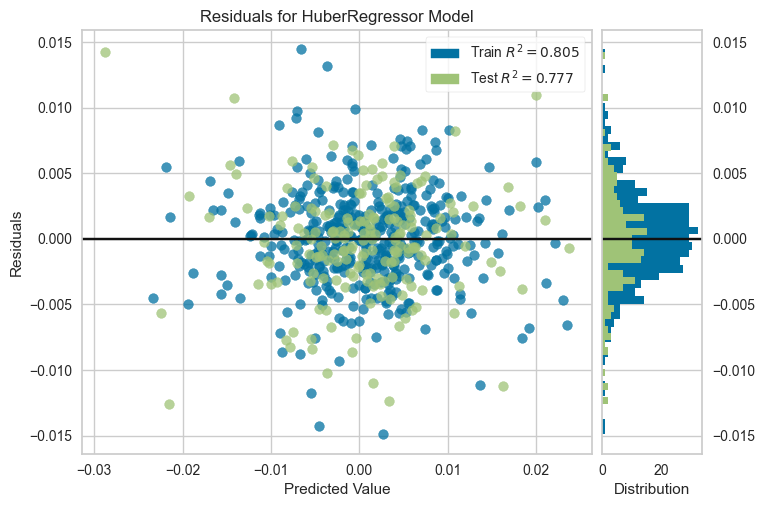

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0028,0.0000,0.0037,0.6721,0.0035,1.7879


In [38]:
plot_model(best_model_mv, plot='residuals')

predictions_mv = predict_model(best_model_mv, data=test_data_mv)

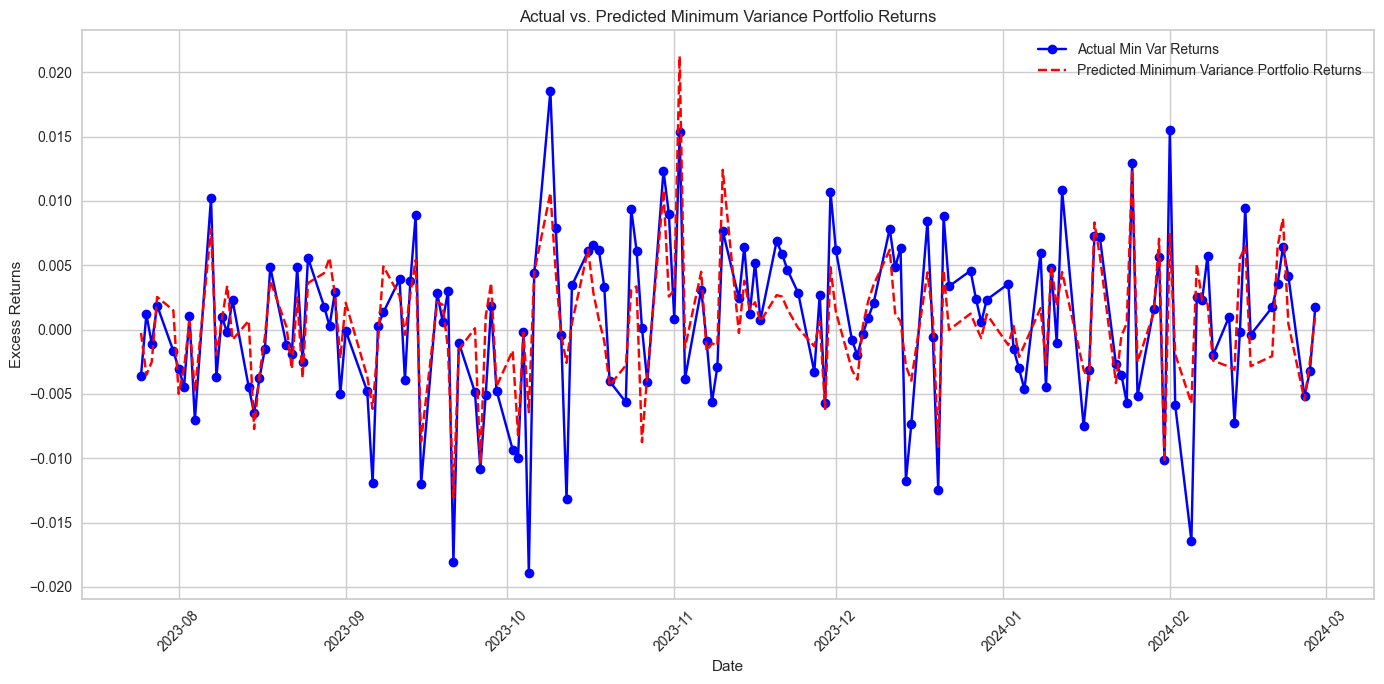

In [39]:
# Plotting the actual vs. predicted excess returns for our Equal Weighted Portfolio
plt.figure(figsize=(14, 7))
plt.plot(predictions_mv.index, predictions_mv['MV_Returns'], label='Actual Min Var Returns', color='blue', marker='o')
plt.plot(predictions_mv.index, predictions_mv['prediction_label'], label='Predicted Minimum Variance Portfolio Returns', color='red', linestyle='--')

plt.title('Actual vs. Predicted Minimum Variance Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### COMMENTS:

The R2 value for the Huber Regressor dropped to 0.6721 in the test phase. While this decrease is expected when moving from training to test data, the model still retains a significant explanatory power, suggesting it has captured meaningful patterns in the data.

The MAE and RMSE values in the test phase are consistent with those in the training phase, indicating the model's predictions are close to actual returns, even in unseen data.

## 5. Observe the risk and return characteristics of your updated portfolio and the initial portfolio in the second part of the data (test data). Report the investment statistics (Choose your own criteria set: Portfolio variance, Sharpe ratio, Sortino ratio etc.)


In [40]:
predictions

,Mkt-RF,SMB,HML,RMW,CMA,EW_Returns,prediction_label
2023-07-24,0.31,-0.03,0.78,0.96,-0.22,0.004259,0.002751
2023-07-25,0.25,-0.23,-0.79,0.47,-0.40,-0.000876,-0.000166
2023-07-26,0.02,0.87,1.02,-0.35,0.64,-0.005616,0.002808
2023-07-27,-0.75,-0.81,0.26,0.39,0.13,-0.005575,-0.004171
2023-07-28,1.14,0.42,-0.32,-0.76,-0.39,0.006763,0.009390
...,...,...,...,...,...,...,...
2024-02-22,2.01,-1.56,-1.30,0.38,-1.18,0.011112,0.015226
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.001418,-0.000390
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,-0.003934,-0.002543
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,-0.000906,0.002476


In [41]:
predictions_mv

,Mkt-RF,SMB,HML,RMW,CMA,EW_Returns,MV_Returns,prediction_label
2023-07-25,0.25,-0.23,-0.79,0.47,-0.40,-0.000876,-0.003592,-0.000255
2023-07-26,0.02,0.87,1.02,-0.35,0.64,-0.005616,0.001190,-0.003527
2023-07-27,-0.75,-0.81,0.26,0.39,0.13,-0.005575,-0.001113,-0.002507
2023-07-28,1.14,0.42,-0.32,-0.76,-0.39,0.006763,0.001865,0.002537
2023-07-31,0.26,1.00,-0.09,-0.94,0.06,0.006460,-0.001657,0.001502
...,...,...,...,...,...,...,...,...
2024-02-22,2.01,-1.56,-1.30,0.38,-1.18,0.011112,0.006402,0.008628
2024-02-23,0.02,0.32,-0.03,0.09,-0.11,0.001418,0.004163,0.000453
2024-02-26,-0.26,0.97,-0.11,-0.74,-0.01,-0.003934,-0.005181,-0.005489
2024-02-27,0.27,1.24,-0.45,-1.14,0.67,-0.000906,-0.003228,-0.002488


In [62]:
# Variance of actual and predicted returns for EW Portfolio
ew_variance_actual = predictions['EW_Returns'].var()
ew_variance_predicted = predictions['prediction_label'].var()

# Variance of actual and predicted returns for MV Portfolio
mv_variance_actual = predictions_mv['MV_Returns'].var()
mv_variance_predicted = predictions_mv['prediction_label'].var()

# Sharpe Ratios for EW Portfolio
ew_sharpe_actual = predictions['EW_Returns'].mean() / predictions['EW_Returns'].std()
ew_sharpe_predicted = predictions['prediction_label'].mean() / predictions['prediction_label'].std()

# Sharpe Ratios for MV Portfolio
mv_sharpe_actual = predictions_mv['MV_Returns'].mean() / predictions_mv['MV_Returns'].std()
mv_sharpe_predicted = predictions_mv['prediction_label'].mean() / predictions_mv['prediction_label'].std()

# Printing out the variances
print(f"EW Portfolio Actual Variance: {ew_variance_actual}")
print(f"EW Portfolio Predicted Variance: {ew_variance_predicted}")
print(f"MV Portfolio Actual Variance: {mv_variance_actual}")
print(f"MV Portfolio Predicted Variance: {mv_variance_predicted}")
print("-----------------")

# Printing out the calculated Sharpe ratios
print(f"EW Portfolio Actual Sharpe Ratio: {ew_sharpe_actual}")
print(f"EW Portfolio Predicted Sharpe Ratio: {ew_sharpe_predicted}")
print(f"MV Portfolio Actual Sharpe Ratio: {mv_sharpe_actual}")
print(f"MV Portfolio Predicted Sharpe Ratio: {mv_sharpe_predicted}")

EW Portfolio Actual Variance: 4.436402377905324e-05
EW Portfolio Predicted Variance: 4.2002183497767866e-05
MV Portfolio Actual Variance: 4.1093626350630075e-05
MV Portfolio Predicted Variance: 2.2195084560352278e-05
-----------------
EW Portfolio Actual Sharpe Ratio: 0.12810689210891724
EW Portfolio Predicted Sharpe Ratio: 0.16067895780847666
MV Portfolio Actual Sharpe Ratio: 0.06382080912590027
MV Portfolio Predicted Sharpe Ratio: 0.09745686602605871


In [43]:
# Define a function to calculate downside deviation
def downside_deviation(returns, target=0):
    negative_returns = returns[returns < target]
    squared_deviations = negative_returns ** 2
    mean_squared_deviations = squared_deviations.mean()
    return np.sqrt(mean_squared_deviations)

# Sortino Ratios for EW Portfolio
ew_downside_deviation_actual = downside_deviation(predictions['EW_Returns'])
ew_downside_deviation_predicted = downside_deviation(predictions['prediction_label'])
ew_sortino_actual = predictions['EW_Returns'].mean() / ew_downside_deviation_actual
ew_sortino_predicted = predictions['prediction_label'].mean() / ew_downside_deviation_predicted

# Sortino Ratios for MV Portfolio
mv_downside_deviation_actual = downside_deviation(predictions_mv['MV_Returns'])
mv_downside_deviation_predicted = downside_deviation(predictions_mv['prediction_label'])
mv_sortino_actual = predictions_mv['MV_Returns'].mean() / mv_downside_deviation_actual
mv_sortino_predicted = predictions_mv['prediction_label'].mean() / mv_downside_deviation_predicted

# Printing out the Sortino ratios
print(f"EW Portfolio Actual Sortino Ratio: {ew_sortino_actual}")
print(f"EW Portfolio Predicted Sortino Ratio: {ew_sortino_predicted}")
print(f"MV Portfolio Actual Sortino Ratio: {mv_sortino_actual}")
print(f"MV Portfolio Predicted Sortino Ratio: {mv_sortino_predicted}")

EW Portfolio Actual Sortino Ratio: 0.1411951631307602
EW Portfolio Predicted Sortino Ratio: 0.1678365915211059
MV Portfolio Actual Sortino Ratio: 0.0620473176240921
MV Portfolio Predicted Sortino Ratio: 0.1047272388377385


### 6. Compare the performance of your updated portfolio with the initial portfolio in the second part of the data period. Discuss your results.

### COMMENTS: 
#### Sharpe Ratio:
- EW Portfolio: The predicted Sharpe ratio (0.1607) is higher than the actual Sharpe ratio (0.1281). This indicates that the predicted returns of the EW portfolio, adjusted for risk, were more favorable than what was actually realized. This could imply that the predictive model was somewhat optimistic in terms of risk-adjusted returns for the EW portfolio.

- MV Portfolio: Similar to the EW portfolio, the predicted Sharpe ratio (0.0975) for the MV portfolio is higher than the actual Sharpe ratio (0.0638). This also suggests that the model's predictions were more optimistic about the risk-adjusted returns of the MV portfolio compared to the actual outcomes.

#### Sortino Ratio:
- EW Portfolio: The predicted Sortino ratio (0.1678) exceeds the actual Sortino ratio (0.1412). Since the Sortino ratio focuses on downside risk, this difference suggests that the predictive model expected the EW portfolio to handle negative returns better than it actually did.

- MV Portfolio: The actual Sortino ratio (0.0620) is lower than the predicted Sortino ratio (0.1047). This further indicates that the predictions for the MV portfolio were overly optimistic about its ability to avoid significant losses.

The differences in both the Sharpe and Sortino ratios between the actual and predicted portfolios suggest that the predictive models were more optimistic about the portfolios' performances. This optimism was observed in both risk-adjusted return metrics and downside risk management.

It's crucial to consider the limitations and assumptions of the predictive models used. Factors such as model overfitting, market volatility, and unforeseen economic events can all impact the accuracy of predictions.

In conclusion, while the predictive models showed promising risk-adjusted returns, the actual performance did not fully meet these expectations. This discrepancy underscores the need for cautious optimism when relying on predictive analytics in portfolio management and the value of diversification and risk assessment in investment decision-making.